In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp
import scipy.interpolate as inter
import noordermeer as noord

from datetime import datetime
import time as t

In [2]:
# Data and uncertainties
starttime = t.time()

data = dp.getXYdata_wXYerr('data/final/nord-120kpc-datapoints.txt')
data_total = dp.getXYdata('data/final/nord-120kpc-total.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#for uncertainty band: (form noordermeer's thesis, p.)
#delta_i = 3     # guessed value
#v_i = (v_dat / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))

# Uncertainty band (traced)
greyb_bottom = noord.greyb_bottom
greyb_top    = noord.greyb_top

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
#v_err1_array = np.asarray(v_err1)

#Express as weights
weighdata = 1/(np.sqrt(v_err1**2 + noord.band**2))

In [3]:
# Function for fitting only prefactors + halo's parameters + traced disk and gas
def g(r,M,rc,rho00,c,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 
                   + nf.h_v(r,rc,rho00,load=True)**2 
                   + c**2*nf.b_v(r,load=True)**2 
                   + pref**2*nf.d_thief(r)**2
                   + gpref**2*nf.g_thief(r)**2)

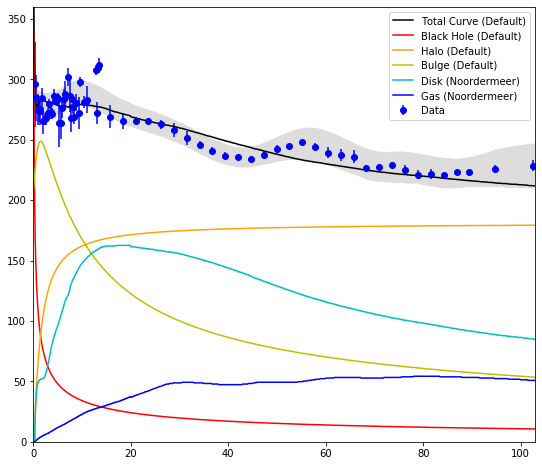

In [4]:
#Plot default
rval = np.arange(0.1,200,0.1)

plt.figure(figsize=(9.0,8.0))
plt.xlim(0,103)
plt.ylim(0,360)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),color='k',label='Total Curve (Default)')
plt.plot(rval,nf.bh_v(rval,load=True),color='r',label='Black Hole (Default)')
plt.plot(rval,nf.h_v(rval,load=True),color='orange',label='Halo (Default)')
plt.plot(rval,nf.b_v(rval,load=True),color='y',label='Bulge (Default)')
#plt.plot(rval,nf.d_v(rval,load=True),color='m',label='Disk (Default)')
plt.plot(rval,nf.d_thief(rval),color='c',label='Disk (Noordermeer)')
plt.plot(rval,nf.g_thief(rval),color='blue',label='Gas (Noordermeer)')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

In [5]:
# LMFit

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()

#Black Hole
g_params.add('M', value=nf.Mbh_def, min=1.0e8)      #Mass

#Halo
g_params.add('rc', value=nf.h_rc, min=0.1)          #Core radius (kpc)
g_params.add('rho00', value=nf.hrho00_c, min=0)     #Central density 

#Bulge
g_params.add('c', value=1, min=0, max=100)          #Prefactor

#Disk
g_params.add('pref', value=1, min=0, max=100)       #Prefactor

#Gas
g_params.add('gpref', value=1,min=1, max=1.01)       #Prefactor

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [6]:
# Define for plotting
bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty()

In [7]:
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


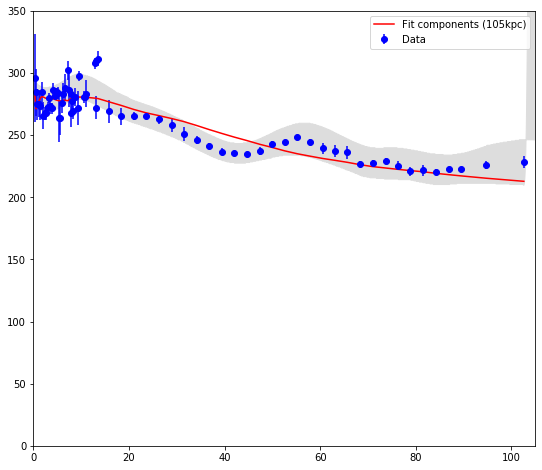

In [8]:
# Plot fitted curves to 105kpc
plt.figure(figsize=(9.0,8.0))
plt.xlim(0,105)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (125kpc)')
#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')
plt.plot(r_dat,bestg,'r-',label='Fit components (105kpc)')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')
#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

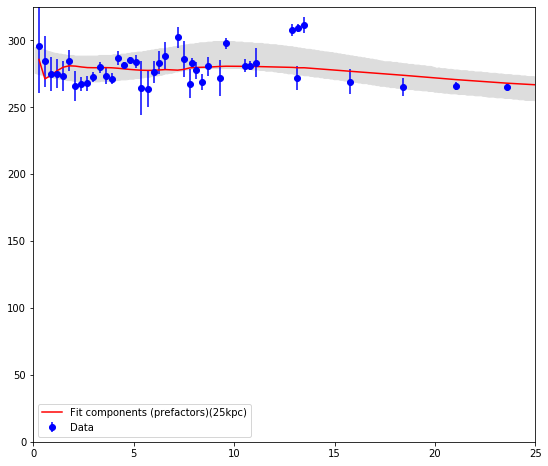

In [9]:
# Plot to 25kpc
plt.figure(figsize=(9.0,8.0))
plt.xlim(0,25)
plt.ylim(0,325)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')
plt.plot(r_dat,bestg,'r-',label='Fit components (prefactors)(25kpc)')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')
#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_25kpc.png')
plt.show()

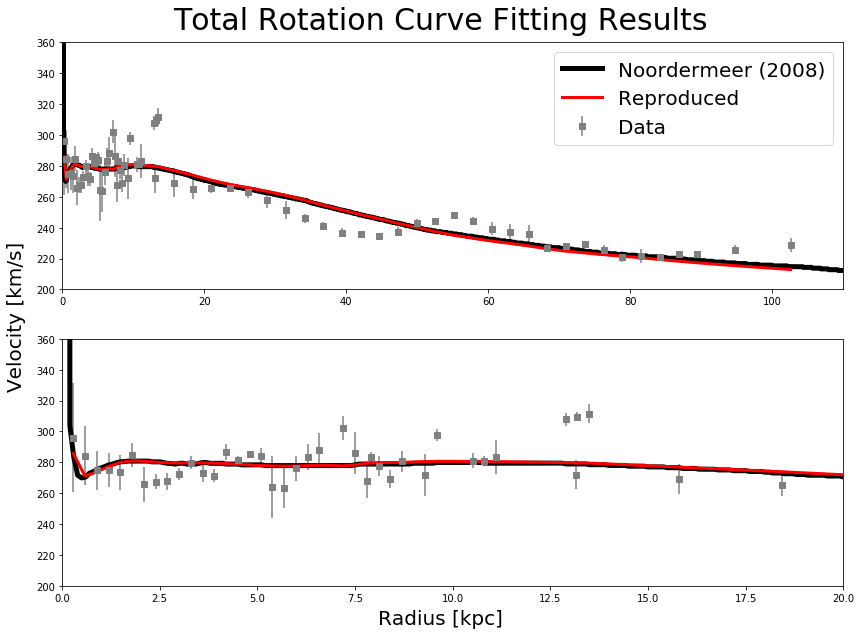

In [10]:
# Total curve
# convert to numpy arrays
r_total = np.asarray(data_total['xx'])
v_total = np.asarray(data_total['yy'])

# smoothing - new, `spline` would not run on my computer
t, c, k = inter.splrep(r_total,v_total)
f_v_total = inter.BSpline(t,c,k)

#f_v_total = inter.spline(r_total,v_total,rval,kind='smoothest')


# Plot to 120kpc
fig, axs = plt.subplots(2,1,figsize=(14,10))
#fig = plt.figure(figsize=(14,10.0))

#plt.xlim(0,20)
#plt.ylim(0,360)

ax1 = axs[0]
ax1.errorbar(r_dat,v_dat,yerr=v_err1,color='gray',fmt='s',label='Data')
ax1.plot(rval, f_v_total(rval), color='k', linewidth=5,label='Noordermeer (2008)') 
ax1.plot(r_dat,bestg,'r-',linewidth=3,label='Reproduced')
ax1.set_xlim([0, 110])
ax1.set_ylim([200, 360])
ax1.legend(loc="upper right", prop={'size': 20})

ax2 = axs[1]
plt.errorbar(r_dat,v_dat,yerr=v_err1,color='gray',fmt='s',label='Data')
plt.plot(rval, f_v_total(rval), color='k', linewidth=5,label='Noordermeer (2008)') 
plt.plot(r_dat,bestg,'r-',linewidth=3,label='Reproduced')
ax2.set_xlim([0, 20])
ax2.set_ylim([200, 360])


#plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')
#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd')

fig.text(0.5, 0.08, 'Radius [kpc]', ha='center', va='center',fontsize=20)
fig.text(0.08, 0.5, 'Velocity [km/s]', ha='center', va='center', rotation='vertical',fontsize=20)
fig.suptitle('Total Rotation Curve Fitting Results', fontsize=30,y=.93)
#plt.set_title('Total Rotation Curve Fitting Results', fontsize=20) 


plt.savefig('Reproducibility_Paper_Figures/total_fitting_results.png')

In [11]:
# Define for plotting cont.
g_dict = g_fit.best_values
g_M = g_dict['M']
g_c = g_dict['c']
g_pref = g_dict['pref']
g_rc = g_dict['rc']
g_hrho00 = g_dict['rho00']
g_gpref = g_dict['gpref']

g_curve = g(rval,g_M,g_rc,g_hrho00,g_c,g_pref,g_gpref)
bh_curve = nf.bh_v(rval,g_M)
halo_curve = nf.h_v(rval,g_rc,g_hrho00)
bulge_curve = g_c*nf.b_v(rval, load=True)
#disk_curve = g_pref*nf.d_v(rval, load=True)
disk_curve = g_pref*nf.d_thief(rval)
gas_curve = g_gpref*nf.g_thief(rval)

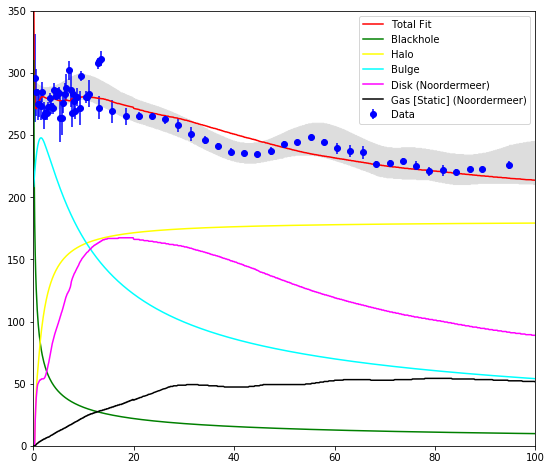

In [12]:
# Plot each fitted component to 100kpc
plt.figure(figsize=(9.0,8.0))
plt.xlim(0,100)
plt.ylim(0,350)
plt.plot(rval,g_curve,'r-',label='Total Fit')
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')


#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd',label='Uncertainty Band')
plt.plot(rval,bh_curve,'green',label='Blackhole')
plt.plot(rval,halo_curve,'yellow',label='Halo')
plt.plot(rval,bulge_curve,'cyan',label='Bulge')
plt.plot(rval,disk_curve,'magenta',label='Disk (Noordermeer)')
plt.plot(rval,gas_curve,'black',label='Gas [Static] (Noordermeer)')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')


#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_100kpc.png')
plt.show()

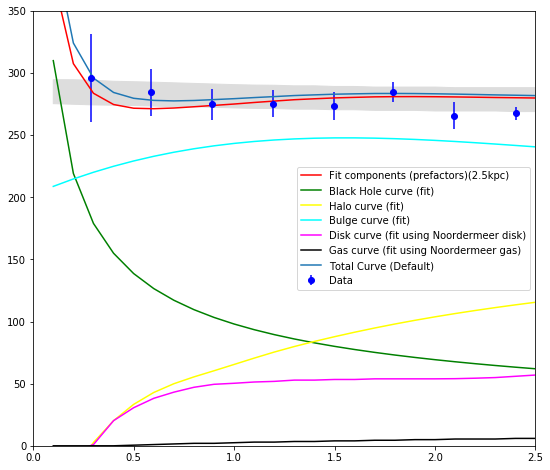

In [13]:
# Plot each fitted component to 2.5 kpc
plt.figure(figsize=(9.0,8.0))
plt.xlim(0,2.5)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(rval,g_curve,'r-',label='Fit components (prefactors)(2.5kpc)')
plt.plot(rval,bh_curve,'green',label='Black Hole curve (fit)')
plt.plot(rval,halo_curve,'yellow',label='Halo curve (fit)')
plt.plot(rval,bulge_curve,'cyan',label='Bulge curve (fit)')
plt.plot(rval,disk_curve,'magenta',label='Disk curve (fit using Noordermeer disk)')
plt.plot(rval,gas_curve,'black',label='Gas curve (fit using Noordermeer gas)')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')

plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_20kpc.png')
plt.show()

In [14]:
# Explanation of parameters 

# Bulge
print('Bulge')
print('Scaling constant,         C = {:.2f}'.format(g_c))

print('')


# Disk
print('Disk')
print('Scaling constant,         prefactor = {:.3f}'.format(g_pref))

print('')


# Black Hole
print('Black Hole')
print('Mass of the Black Hole,   M(bh) = {:.3e} [solar masses]'.format(g_M))
print('')


# Dark Halo
print('Dark Halo')
print('Halo central density,     rho00 = {:.3e} [solar mass/kpc^3]'.format(g_hrho00))
print('Core radius,              rc = {:.2f} [kpc]'.format(g_rc))


Bulge
Scaling constant,         C = 1.00

Disk
Scaling constant,         prefactor = 1.030

Black Hole
Mass of the Black Hole,   M(bh) = 2.234e+09 [solar masses]

Dark Halo
Halo central density,     rho00 = 3.100e+08 [solar mass/kpc^3]
Core radius,              rc = 1.40 [kpc]


In [15]:
endtime = t.time()     #put this at end of code
print('Total Time:')
runtime = endtime - starttime

if runtime<=60:
    minutes, runtime= divmod(runtime, 60)
    print(str(round(runtime))+'s')
elif runtime>60 and runtime<=3600:
    minutes, runtime= divmod(runtime, 60)
    print(str(round(minutes))+'min', str(round(runtime))+'s')
elif runtime>3600 and runtime<=86400:
    minutes = runtime/60
    hours, minutes= divmod(minutes, 60)
    print(str(round(hours))+'hrs', str(round(minutes))+'min')
elif runtime>86400:
    hours = runtime/3600
    days, hours= divmod(hours, 24)
    print(str(round(days))+'days', str(round(hours))+'hrs')

AttributeError: 'numpy.ndarray' object has no attribute 'time'